# Photometric Calibration

The purpose of this notebook is to define the workflow for the calibration of photometry from the microlensing pipeline. 

In [1]:
from sys import path as pythonpath
from os import path, getcwd
pythonpath.append('../..')
from astropy.coordinates import SkyCoord
from astropy import units as u 
from astropy.table import Table, Column
from astropy.io import ascii
import astroquery
from matplotlib import pyplot as plt
import numpy as np
from scipy.odr import Model, Data, ODR
import h5py
import microlensing_photometry.logistics.GaiaTools.GaiaCatalog as GC
import microlensing_photometry.infrastructure.observations as lcoobs
from microlensing_photometry.photometry import aperture_photometry as lcophot
from microlensing_photometry.photometry import conversions
from microlensing_photometry.astrometry import wcs as lcowcs

### Setup

Logging is switched off for the purposes of this notebook. 

In [2]:
log = None

In [3]:
class Arguments(object):
    """Class to manage arguments needed by the pipeline in the format of a class instance"""

    def __init__(self):
        self.directory = None

In [4]:
# We create two arguments instances here because we have both ip and gp datasets reduced separately. 
args_ip = Arguments()
args_ip.directory = '/Users/rstreet/OMEGAII/data_reduction/OGLE-2024-BLG-0034/1m0_ip'

args_gp = Arguments()
args_gp.directory = '/Users/rstreet/OMEGAII/data_reduction/OGLE-2024-BLG-0034/1m0_gp'

### Loading data from a pipeline reduction

Using OGLE-2024-BLG-0034 as our example for this workflow. 

In [5]:
target = SkyCoord('17:44:10.400', '-39:06:47.60', frame='icrs', unit=(u.hourangle, u.deg))

The pipeline uses source catalogs drawn from Gaia DR3.  Here we can load a pre-existing catalog already built from a previous pipeline run as our reference catalog for astrometry and photometry. 

Interestingly, the Gaia catalogs produced for the same target but for datasets based on different filters appear to be slightly different.  
Going forward the pipeline should be generalized to draw one catalog for all filter datasets. 

In the meantime, we load both catalogs for each filter

In [6]:
gaia_catalog_ip = GC.collect_Gaia_catalog(
        target.ra.deg,
        target.dec.deg,
        20,
        row_limit = 10000,
        catalog_name='Gaia_catalog.dat',
        catalog_path=args_ip.directory,
        log=log
    )

gaia_catalog_gp = GC.collect_Gaia_catalog(
        target.ra.deg,
        target.dec.deg,
        20,
        row_limit = 10000,
        catalog_name='Gaia_catalog.dat',
        catalog_path=args_gp.directory,
        log=log
    )

Next we need to chose images from our observed datasets to use as reference images per filter.  The pipeline keeps track of the images within a given dataset in the observation table.  This is stored as a text file that we can simply load.  

In [7]:
obs_set_ip = lcoobs.get_observation_metadata(args_ip, log=log)
obs_set_gp = lcoobs.get_observation_metadata(args_gp, log=log)

# Display an example of the obs_set content
obs_set_ip.table

file,facility_code,filter,dateobs,exptime,RA,Dec,airmass,fwhm,moon_fraction,moon_separation,sky_bkgd,HJD,CTYPE1,CTYPE2,CRPIX1,CRPIX2,CRVAL1,CRVAL2,CUNIT1,CUNIT2,CD1_1,CD1_2,CD2_1,CD2_2,WCSERR,NAXIS1,NAXIS2,WMSCLOUD
str36,str18,str2,str23,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,str8,float64,float64,float64,float64,str3,str3,float64,float64,float64,float64,int64,int64,int64,float64
coj1m003-fa19-20240903-0113-e91.fits,coj-domb-1m0a-fa19,ip,2024-09-03T11:11:46.201,68.199,266.04332916666664,-39.11323055555556,1.1374612,1.8981338741174743,0.0012767,102.2463311,254.02047893483518,2460556.968419821,RA---TAN,DEC--TAN,2048.0,2048.0,266.0433336,-39.1132222,deg,deg,0.0001081,-0.0,-0.0,-0.0001081,4,4096,4096,-33.0493333
cpt1m010-fa14-20240419-0187-e91.fits,cpt-doma-1m0a-fa14,ip,2024-04-19T21:59:57.467,93.261,266.0433208333333,-39.11321111111111,1.6809987,2.872100509049238,0.8514893,102.4411537,1025.424747148395,2460420.420233866,RA---TAN,DEC--TAN,2048.0,2048.0,266.0433323,-39.1132224,deg,deg,0.0001081,-0.0,-0.0,-0.0001081,4,4096,4096,-25.032
lsc1m009-fa04-20240714-0242-e91.fits,lsc-domb-1m0a-fa04,ip,2024-07-15T04:30:40.287,78.001,266.04335833333334,-39.11321388888889,1.0756408,2.09106302001115,0.610573,52.1732018,684.8640350497964,2460506.693494876,RA---TAN,DEC--TAN,2048.0,2048.0,266.0433335,-39.1132222,deg,deg,0.0001081,-0.0,-0.0,-0.0001081,4,4096,4096,-26.644
lsc1m005-fa15-20240722-0206-e91.fits,lsc-doma-1m0a-fa15,ip,2024-07-23T04:23:30.450,70.5,266.0433458333333,-39.11320833333333,1.1143431,3.3465231933367976,0.955104,58.2041851,1259.7402369487459,2460514.688099666,RA---TAN,DEC--TAN,2048.0,2048.0,266.0433336,-39.1132222,deg,deg,0.0001081,-0.0,-0.0,-0.0001081,4,4096,4096,-21.784
lsc1m004-fa03-20240713-0223-e91.fits,lsc-domc-1m0a-fa03,ip,2024-07-14T06:50:52.942,77.698,266.04334166666666,-39.113225,1.4900462,2.7232473182090873,0.5248183,62.7689815,292.0978224501722,2460505.7908986965,RA---TAN,DEC--TAN,2048.0,2048.0,266.043334,-39.1132223,deg,deg,0.0001081,-0.0,-0.0,-0.0001081,4,4096,4096,-23.62
cpt1m012-fa06-20240613-0318-e91.fits,cpt-domc-1m0a-fa06,ip,2024-06-14T03:05:00.301,79.993,266.04333333333335,-39.113197222222226,1.5881184,2.160901790084602,0.4872833,95.4081173,507.19034621056085,2460475.6345743635,RA---TAN,DEC--TAN,2048.0,2048.0,266.0433342,-39.1132224,deg,deg,0.0001081,-0.0,-0.0,-0.0001081,4,4096,4096,-27.586
cpt1m012-fa06-20240613-0319-e91.fits,cpt-domc-1m0a-fa06,ip,2024-06-14T03:06:48.307,79.973,266.04333749999995,-39.11322222222223,1.5998429,2.2869415436008174,0.4874401,95.3898858,505.009081389471,2460475.6358243236,RA---TAN,DEC--TAN,2048.0,2048.0,266.0433342,-39.1132224,deg,deg,0.0001081,-0.0,-0.0,-0.0001081,4,4096,4096,-27.66
lsc1m009-fa04-20240714-0241-e91.fits,lsc-domb-1m0a-fa04,ip,2024-07-15T04:28:55.046,77.999,266.0433458333333,-39.113225,1.0732382,2.0771723393208146,0.6104726,52.1855527,678.1084030234439,2460506.6922768475,RA---TAN,DEC--TAN,2048.0,2048.0,266.0433335,-39.1132222,deg,deg,0.0001081,-0.0,-0.0,-0.0001081,4,4096,4096,-27.24
lsc1m004-fa03-20240714-0144-e91.fits,lsc-domc-1m0a-fa03,ip,2024-07-15T03:21:51.310,77.902,266.04329583333333,-39.113225,1.0171847,2.170119858899667,0.6068714,52.6357618,379.2449869009775,2460506.6457072133,RA---TAN,DEC--TAN,2048.0,2048.0,266.0433334,-39.1132222,deg,deg,0.0001081,-0.0,-0.0,-0.0001081,4,4096,4096,-26.132


With multiband datasets for a single object, ideally we want the reference images for different filters to be taken at least on the same good-quality night in order to be able to use the photometry for color-magnitude analysis.  

In future, we will want the pipeline to automatically select reference images and this is on the list of tasks to implement.  

In the meantime, the following images have been manually selected by data inspection.

In [8]:
ref_image_gp = 'lsc1m009-fa04-20240809-0165-e91.fits'
ref_image_ip = 'lsc1m009-fa04-20240809-0169-e91.fits'

We can identify the location of these files in the obs_set tables, which also gives us the index of these images in the photometry arrays. 

In [9]:
ref_index_ip = np.where(obs_set_ip.table['file'] == ref_image_ip)[0][0]
ref_index_gp = np.where(obs_set_gp.table['file'] == ref_image_gp)[0][0]

Next we need to load the pipeline's photometry for these reference images.  This is available from the pipeline's timeseries photometry output files for the different filter datasets.  

In [10]:
dataset_ip = lcophot.AperturePhotometryDataset(
    file_path = path.join(args_ip.directory, 'aperture_photometry.hdf5')
)

dataset_gp = lcophot.AperturePhotometryDataset(
    file_path = path.join(args_gp.directory, 'aperture_photometry.hdf5')
)

Each dataset object contains several tables and arrays as attributes, including the fluxes for all stars in all images. 
The arrays are ordered according to [nstars, nimages], and the list of stars is in exactly the same order as the Gaia catalog for the dataset. 

So we can easily extract the photometry for all of the Gaia stars within our chosen reference image, e.g...

In [11]:
dataset_ip.flux[:,ref_index_ip]

array([ 8.70599229e+04,  5.17271584e+04,  6.28956995e+04, ...,
       -8.78122475e+00, -9.50092030e+01,  1.62288399e+02], shape=(9964,))

### Photometric calibration

Now let's compare the Gaia photometry for these stars with the pipeline's for our chosen reference image in each bandpass, and determine the transformation between the instrumental magnitudes and the calibrated Gaia passbands.  

There are published transformations between the Gaia passbands and the SDSS filters used for OMEGA, but these work in magnitudes.  So our first step is to convert both Gaia catalogs from fluxes to magnitudes and perform this transformation.  The following functions were extracted from pyDANDIA. 

In [12]:
def gaia_flux_to_mag(Gflux, Gferr, passband="G", system="AB"):
    """Function to convert Gaia flux measurements to photometric magnitudes
    on the VEGAMAG system, using the zeropoints produced from Gaia
    Data Release 3 published in Busso, G, Montegriifo, P, 
    https://gea.esac.esa.int/archive/documentation/GDR3/Data_processing/chap_cu5pho/cu5pho_sec_photProc/cu5pho_ssec_photCal.html
    their table 5.4. 
    Coefficients for both Vega and AB mags are supported, with AB mags being the default. 
    
    Parameters:
        Gflux   float or array   Instrumental magnitude values 
        Gferr   float or arrray  Instrumental magnitude uncertainties
        passband  string         Gaia passband to calibrate to, one of {'G', 'G_BP', 'G_RP'}
        system    string         Photometric system to calibrate to, one of {'AB' (default), 'Vega'}

    Returns:
        Gmag   float or array    Calibrated magnitude 
        Gmerr  float or array    Calibrated magnitude uncertainties
    """

    def phot_conversion(flux, ferr):
        mag = ZP - 2.5 * np.log10(flux)
        merr = (2.5 / np.log(10.0)) * ferr / flux
        return mag, merr

    match system:
        case 'AB':
            if passband == "G":
                ZP = 25.8010
                sigZP = 0.0028
            elif passband == 'G_BP':
                ZP = 25.3540
                sigZP = 0.0023
            elif passband == 'G_RP':
                ZP = 25.1040
                sigZP = 0.0016
            else:
                raise ValueError(
                    'No Gaia photometric transform available for passband ' 
                    + passband + ' under the ' + system + ' system'
                    )
        case 'Vega':
            if passband == "G":
                ZP = 25.6874
                sigZP = 0.0028
            elif passband == 'G_BP':
                ZP = 25.3385
                sigZP = 0.0028	
            elif passband == 'G_RP':
                ZP = 24.7479
                sigZP = 0.0028
            else:
                raise ValueError(
                    'No Gaia photometric transform available for passband ' 
                    + passband + ' under the ' + system + ' system'
                    )
                    
    if type(Gflux) == type(Column()):

        idx = np.where(Gflux > 0.0)
        Gmag = np.zeros(len(Gflux))
        Gmerr = np.zeros(len(Gflux))

        (Gmag[idx],Gmerr[idx]) = phot_conversion(Gflux[idx], Gferr[idx])

    else:

        if Gflux > 0.0:
            (Gmag,Gmerr) = phot_conversion(Gflux, Gferr)
        else:
            Gmag = 0.0
            Gmerr = 0.0

    return Gmag, Gmerr

In [13]:
gaia_catalog_gp

ra,dec,source_id,ra_error,dec_error,phot_g_mean_flux,phot_g_mean_flux_error,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_rp_mean_flux,phot_rp_mean_flux_error,pm,pm_ra,pm_ra_error,pm_dec,pm_dec_error,parallax,parallax_error
float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
266.11385681623,-39.11247724299,5961147189382398976,0.013,0.0101,1195600.0,172.33999633789062,442500.0,171.97999572753906,1077500.0,265.7900085449219,22.96,-9.199,0.017000000923871994,-21.036,0.009999999776482582,1.3356,0.014299999922513962
266.05473556396,-39.15453985943,5961146669611297536,0.0219,0.0174,492060.0,168.47999572753906,221110.0,116.55999755859375,390300.0,144.7100067138672,4.769,-2.244,0.02800000086426735,-4.207,0.017000000923871994,0.665,0.025800000876188278
266.01147797338,-39.06860415158,5961194910687451136,0.0206,0.0157,427540.0,191.4199981689453,85593.0,89.93800354003906,521040.0,413.4200134277344,7.634,-3.217,0.02500000037252903,-6.923,0.014999999664723873,0.4797,0.02280000038444996
266.06202898821,-39.09010282397,5961194056067729664,0.0149,0.012,259520.0,41.433998107910156,90272.0,59.03099822998047,244000.0,83.97699737548828,5.095,-0.704,0.01899999938905239,-5.046,0.010999999940395355,0.6952,0.01489999983459711
266.10912473996,-39.10531269256,5961147253726760192,0.0133,0.0104,223060.0,36.24599838256836,94908.0,43.180999755859375,183040.0,52.393001556396484,10.294,-2.51,0.017999999225139618,-9.983,0.009999999776482582,1.4157,0.014700000174343586
266.00217960553,-39.11687293895,5961192475519806592,0.058,0.0455,179860.0,131.52999877929688,165100.0,711.8699951171875,182640.0,362.6400146484375,3.756,-2.73,0.06800000369548798,-2.581,0.041999999433755875,0.7009,0.06589999794960022
266.07708868759,-39.10174886759,5961193845531989248,0.0146,0.0116,167870.0,22.805999755859375,50551.0,31.57900047302246,170830.0,40.9010009765625,7.59,-7.291,0.017999999225139618,-2.111,0.010999999940395355,0.5629,0.01549999974668026
266.07439897156,-39.06810008523,5961194468384616576,0.0177,0.0129,123030.0,23.50200080871582,39918.0,33.10300064086914,120950.0,38.40599822998047,5.824,-4.333,0.020999999716877937,-3.892,0.012000000104308128,0.6059,0.018400000408291817
266.09940550534,-39.13347377211,5961146772690398464,0.0156,0.0127,121500.0,19.327999114990234,43903.0,29.72800064086914,112100.0,37.6510009765625,2.512,2.171,0.019999999552965164,-1.263,0.012000000104308128,0.4574,0.01759999990463257


In [14]:
def calc_gaia_magnitudes(gaia_catalog):
    """
    Function to convert the fluxes provided in a Gaia catalog to magnitudes

    Parameters:
        gaia_catalog  Table  Output of Gaia DR3 astroquery

    Returns:
        gaia_catalog  Table  Catalog table with columns added for magnitudes
    """

    # Dictionary of Gaia passbands converted to column names to be added to the catalog
    bandpasses = {
        'G': 'G',
        'G_BP': 'BP', 
        'G_RP': 'RP'
    }
    for f, key in bandpasses.items():
        mag, merr = gaia_flux_to_mag(
            gaia_catalog['phot_' + str(key).lower() + '_mean_flux'], 
            gaia_catalog['phot_' + str(key).lower() + '_mean_flux_error'], 
            passband=f
        )

        if key+'mag' in gaia_catalog.colnames: 
            gaia_catalog[key+'mag'] = mag
            gaia_catalog[key+'mag_err'] = merr
            
        else:
            gaia_catalog.add_columns(
                [
                    Column(name=key+'mag', data=mag),
                    Column(name=key+'mag_err', data=merr),
                ]
            )

    return gaia_catalog

In [15]:
def calc_gaia_colours(gaia_catalog):
    """
    Function to calculate the Gaia BP-RP colours and uncertainties

    Parameters:
        gaia_catalog  Table  Output of Gaia DR3 astroquery

    Returns:
        gaia_catalog  Table  Catalog table with columns added for colors
    """

    BP_RP = Column(name='BP-RP', data=(gaia_catalog['BPmag'] - gaia_catalog['RPmag']))

    BPRP_err = Column(
        name='BP-RP_err',
        data=(np.sqrt( (gaia_catalog['BPmag_err'] * gaia_catalog['BPmag_err'])  + \
                            (gaia_catalog['RPmag_err'] * gaia_catalog['RPmag_err']))), 
        )

    if 'BP-RP' in gaia_catalog.colnames:
        gaia_catalog['BP-RP'] = BP_RP
        gaia_catalog['BP-RP_err'] = BPRP_err

    else:
        gaia_catalog.add_columns([BP_RP, BPRP_err])
    
    return gaia_catalog

In [58]:
def transform_gaia_phot_to_SDSS(gaia_catalog):
    """
    Function using the conversion transformations published in

    https://gea.esac.esa.int/archive/documentation/GDR3/Data_processing/chap_cu5pho/cu5pho_sec_photSystem/cu5pho_ssec_photRelations.html

    to calculate the SDSS g, r and i magnitudes based on the Gaia photometry.
    
    Parameters:
        gaia_catalog  Table  Output of Gaia DR3 astroquery

    Returns:
        gaia_catalog  Table  Catalog table with columns added for SDSS photometry
    """

    g_coeff = [-0.1064, -0.4964, -0.09339, 0.004444]
    Gg_err = 0.0872
    r_coeff = [-0.01664, 0.2662, -0.649, 0.08227]
    Gr_err = 0.123
    i_coeff = [-0.01066, 1.298, -0.7595, 0.1492]
    Gi_err = 0.07112	

    def transform_mag(gaia_gmag, gaia_gmerr, gaia_bprp, gaia_bprp_err, coeff, Gf_err):

        dmag = coeff[0]        
        for i in range(1,4,1):
            dmag += coeff[i] * gaia_bprp**i 
        sdss_mag = gaia_gmag - dmag

        sdss_merr = np.sqrt( 
                (gaia_gmerr**2 + coeff[1]**2) * gaia_bprp_err**2 
                + (4.0 * coeff[2]**2 * gaia_bprp**2 * gaia_bprp_err**2) 
                + (9.0 * coeff[3]**2 * gaia_bprp**4 * gaia_bprp_err**2) 
                + (Gf_err**2) 
            )
        
        return sdss_mag, sdss_merr

        
    G_g, g_err = transform_mag(gaia_catalog['Gmag'], gaia_catalog['Gmag_err'], gaia_catalog['BP-RP'], gaia_catalog['BP-RP_err'], g_coeff, Gg_err)

    G_r, r_err = transform_mag(gaia_catalog['Gmag'], gaia_catalog['Gmag_err'], gaia_catalog['BP-RP'], gaia_catalog['BP-RP_err'], r_coeff, Gr_err)

    G_i, i_err = transform_mag(gaia_catalog['Gmag'], gaia_catalog['Gmag_err'], gaia_catalog['BP-RP'], gaia_catalog['BP-RP_err'], i_coeff, Gi_err)
    
    if 'gmag' in gaia_catalog.colnames:
        gaia_catalog['gmag'] = G_g 
        gaia_catalog['gmag_err'] = g_err 
    else:
        gaia_catalog.add_columns(
            [Column(name='gmag', data=G_g), Column(name='gmag_err', data=g_err)]
        )

    if 'rmag' in gaia_catalog.colnames: 
        gaia_catalog['rmag'] = G_r 
        gaia_catalog['rmag_err'] = r_err 
    else:
        gaia_catalog.add_columns(
            [Column(name='rmag', data=G_r), Column(name='rmag_err', data=r_err)]
        )

    if 'imag' in gaia_catalog.colnames:
        gaia_catalog['imag'] = G_i 
        gaia_catalog['imag_err'] = i_err 
    else:
        gaia_catalog.add_columns(
            [Column(name='imag', data=G_i), Column(name='imag_err', data=i_err)]
        )
        
    return gaia_catalog

In [62]:
# Convert Gaia fluxes to magnitudes
gaia_catalog_gp = calc_gaia_magnitudes(gaia_catalog_gp)
gaia_catalog_ip = calc_gaia_magnitudes(gaia_catalog_ip)

# Calculate Gaia colors 
gaia_catalog_gp = calc_gaia_colours(gaia_catalog_gp)
gaia_catalog_ip = calc_gaia_colours(gaia_catalog_ip)

# Transform Gaia photometry to SDSS passbands 
gaia_catalog_gp = transform_gaia_phot_to_SDSS(gaia_catalog_gp)
gaia_catalog_ip = transform_gaia_phot_to_SDSS(gaia_catalog_ip)

gaia_catalog_gp

ra,dec,source_id,ra_error,dec_error,phot_g_mean_flux,phot_g_mean_flux_error,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_rp_mean_flux,phot_rp_mean_flux_error,pm,pm_ra,pm_ra_error,pm_dec,pm_dec_error,parallax,parallax_error,Gmag,Gmag_err,BPmag,BPmag_err,RPmag,RPmag_err,BP-RP,BP-RP_err,gmag,gmag_err,rmag,rmag_err,imag,imag_err
float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
266.11385681623,-39.11247724299,5961147189382398976,0.013,0.0101,1195600.0,172.33999633789062,442500.0,171.97999572753906,1077500.0,265.7900085449219,22.96,-9.199,0.017000000923871994,-21.036,0.009999999776482582,1.3356,0.014299999922513962,10.60703523408189,0.00015650365803942062,11.239216812415389,0.00042197719289387023,10.022956802918078,0.0002678216567426397,1.2162600094973115,0.00049979314835536,11.447341805620667,0.08720042741104257,11.111944868689807,0.12300273802156193,9.894068748684488,0.07112972214888517
266.05473556396,-39.15453985943,5961146669611297536,0.0219,0.0174,492060.0,168.47999572753906,221110.0,116.55999755859375,390300.0,144.7100067138672,4.769,-2.244,0.02800000086426735,-4.207,0.017000000923871994,0.665,0.025800000876188278,11.570954844300292,0.00037175310153006566,11.99247903854858,0.0005723549788606775,11.125503621796877,0.0004025541723803166,0.8669754167517034,0.0006997428695795394,12.175021723699125,0.0872007657219407,11.791012504619532,0.12300273012076172,10.929928661828495,0.0711321584254254
266.01147797338,-39.06860415158,5961194910687451136,0.0206,0.0157,427540.0,191.4199981689453,85593.0,89.93800354003906,521040.0,413.4200134277344,7.634,-3.217,0.02500000037252903,-6.923,0.014999999664723873,0.4797,0.02280000038444996,11.72355811773945,0.0004861103576899442,13.022904378776792,0.0011408520162523245,10.811822337084935,0.0008614791116806448,2.2110820416918564,0.001429576714572907,13.336073691121483,0.08720493587222712,13.435177736615625,0.12308108630280191,10.964530174039552,0.07137462786572976
266.06202898821,-39.09010282397,5961194056067729664,0.0149,0.012,259520.0,41.433998107910156,90272.0,59.03099822998047,244000.0,83.97699737548828,5.095,-0.704,0.01899999938905239,-5.046,0.010999999940395355,0.6952,0.01489999983459711,12.265572918672342,0.00017334460486142833,12.965117338811819,0.0007099886119871371,11.635525434153175,0.0003736756820387133,1.3295919046586437,0.0008023199763800719,13.186633051035988,0.08720113920174757,12.882213916938888,0.12300847703048734,11.542387414025672,0.0711489120969327
266.10912473996,-39.10531269256,5961147253726760192,0.0133,0.0104,223060.0,36.24599838256836,94908.0,43.180999755859375,183040.0,52.393001556396484,10.294,-2.51,0.017999999225139618,-9.983,0.009999999776482582,1.4157,0.014700000174343586,12.429945755338936,0.00017642604107217372,12.910742946028169,0.0004939854890271471,11.947634982217673,0.00031077894813007364,0.9631079638104953,0.0005836139288692693,13.097088882544675,0.08720054474416519,12.718707396272658,0.12300233445165017,11.76169748506959,0.07112957154115725
266.00217960553,-39.11687293895,5961192475519806592,0.058,0.0455,179860.0,131.52999877929688,165100.0,711.8699951171875,182640.0,362.6400146484375,3.756,-2.73,0.06800000369548798,-2.581,0.041999999433755875,0.7009,0.06589999794960022,12.663663527306397,0.0007939891120119825,12.309632316843016,0.004681423541972885,11.950010253794552,0.0021557785435711067,0.3596220630484641,0.005153940968643268,12.960451177020609,0.08723821088303513,12.664679711547194,0.12303128588253982,12.298819552432596,0.07149002490025495
266.07708868759,-39.10174886759,5961193845531989248,0.0146,0.0116,167870.0,22.805999755859375,50551.0,31.57900047302246,170830.0,40.9010009765625,7.59,-7.291,0.017999999225139618,-2.111,0.010999999940395355,0.5629,0.01549999974668026,12.738567273927917,0.0001475028273106665,13.59467562193387,0.0006782549133278191,12.02

Similarly, the pipeline only outputs measurements in fluxes rather than magnitudes so we also need to convert those data. 

In [63]:
# Converting the fluxes for the reference images only
g_inst_mag, g_inst_err_mag, _, _ = conversions.flux_to_mag(dataset_gp.flux[:, ref_index_gp], dataset_gp.err_flux[:, ref_index_gp])
i_inst_mag, i_inst_err_mag, _, _ = conversions.flux_to_mag(dataset_ip.flux[:, ref_index_ip], dataset_ip.err_flux[:, ref_index_ip])

Now we can compare the Gaia photometry in SDSS magnitudes with that from the pipeline, and calculate the transformation from the pipeline's instrumental magnitudes to the calibrated Gaia ones.  

This lends itself to a straight-line fit, so we can adopt the relevant components of the PyDANDIA pipeline.

In [64]:
def phot_func(p,mags):
    """Photometric transform function"""
    # Expected function is of the form p[0]*mags + p[1]
    if len(p) == 2:
        return np.polyval(p,mags)
    else:
        raise IndexError('Photometric transform called with an unexpected number of terms')

def errfunc(p,x,y):
    """Function to calculate the residuals on the photometric transform"""

    return y - phot_func(p,x)

In [65]:
def calc_transform(pinit, x, y):
    """Function to calculate the photometric transformation between a set
    of catalogue magnitudes and the instrumental magnitudes for the same stars
    """

    #(pfit,iexec) = optimize.leastsq(errfunc,pinit,args=(x,y))
    #(pfit,covar_fit) = np.polyfit(x,y,1,cov=True)
    linear_model = Model(phot_func)
    dataset = Data(x, y)
    odr_obj = ODR(dataset, linear_model, beta0=pinit)
    results = odr_obj.run()

    pfit = [results.beta[0], results.beta[1]]
    covar_fit = results.cov_beta*results.res_var

    return pfit, covar_fit

def calc_transform_uncertainty(pfit, x, y):
    """Function to calculate the uncertainty on the calibrated magnitudes,
    based on the scatter of datapoints around the fitted model
    See: http://123.physics.ucdavis.edu/week_0_files/taylor_181-199.pdf
    """

    y2 = phot_func(pfit,x)
    delta = (y - y2)**2
    sigma_y2 = np.sqrt(delta.sum()/float(len(delta)-2))

    return sigma_y2

Both the Gaia catalog and the pipeline's photometry will have some instances of stars with no valid measurements.  
So we have to select valid star measurements.  Since both catalogs have the same star index, 
the indices can be directly compared.

In [66]:
idx1 = gaia_catalog_gp['gmag'] > 12.0 
idx2 = gaia_catalog_gp['gmag'] <= 18.0
idx3 = g_inst_mag > 12.0 
idx4 = g_inst_mag <= 22.0 
valid_gp = idx1 & idx2 & idx3 & idx4

print(gaia_catalog_gp['gmag'][valid_gp].min(), gaia_catalog_gp['gmag'][valid_gp].max())

idx1 = gaia_catalog_ip['imag'] > 10.0 
idx2 = gaia_catalog_ip['imag'] <= 17.5 
idx3 = i_inst_mag > 12.0 
idx4 = i_inst_mag <= 20.0 
valid_ip = idx1 & idx2 & idx3 & idx4

print(gaia_catalog_ip['imag'][valid_ip].min(), gaia_catalog_ip['imag'][valid_ip].max())

12.175021723699125 17.998304119113225
10.109355426135641 17.49893968333531


In [67]:
# Calculate the photometric transformations in gp and ip
pinit = [1.0, 0.0]
pfit_gp, covar_fit_gp = calc_transform(pinit, g_inst_mag[valid_gp], gaia_catalog_gp['gmag'][valid_gp])
print('SDSS-g photometric transform coefficients = ', pfit_gp)

pinit = [1.0, 0.0]
pfit_ip, covar_fit_ip = calc_transform(pinit, i_inst_mag[valid_ip], gaia_catalog_ip['imag'][valid_ip])
print('SDSS-i photometric transform coefficients = ', pfit_ip)

SDSS-g photometric transform coefficients =  [np.float64(0.9236572124227874), np.float64(-0.25736513072093287)]
SDSS-i photometric transform coefficients =  [np.float64(0.978960574291579), np.float64(-1.8024743094647984)]


In [68]:
# Overlay the calibration transform on the instrumental-reference flux plot 
xplot_gp = np.arange(10.0, g_inst_mag[valid_gp].max(), 1.0)
yplot_gp = phot_func(pfit_gp, xplot_gp)
xplot_ip = np.arange(10.0, i_inst_mag[valid_ip].max(), 1.0)
yplot_ip = phot_func(pfit_ip, xplot_ip)

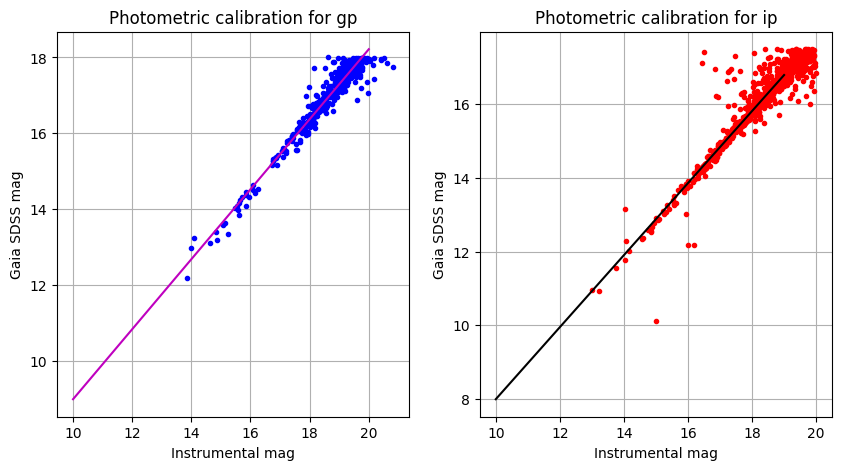

In [69]:
fig, axs = plt.subplots(1,2, figsize=(10,5))

axs[0].plot(g_inst_mag[valid_gp], gaia_catalog_gp['gmag'][valid_gp], 'b.')
axs[0].plot(xplot_gp, yplot_gp, 'm-')
axs[0].set_title('Photometric calibration for gp')

axs[1].plot(i_inst_mag[valid_ip], gaia_catalog_ip['imag'][valid_ip], 'r.')
axs[1].plot(xplot_ip, yplot_ip, 'k-')
axs[1].set_title('Photometric calibration for ip')

axs[0].set_xlabel('Instrumental mag')
axs[0].set_ylabel('Gaia SDSS mag')
axs[1].set_xlabel('Instrumental mag')
axs[1].set_ylabel('Gaia SDSS mag')
axs[0].grid()
axs[1].grid()

plt.show()

### Calibrate the reference image photometry 

We can now use this calibration to calibrate the instrumental photometry for the reference image.

In [70]:
def calc_calibrated_mags(fit_params, covar_fit, mag, err_mag):

    ''' In this function, we propagate uncertainties of the mag calibration. The formula is:

        cal_mag = a*mag+b 

        Therefore, the covariance matrix and Jacobian are:

        C = |sig_a**2 sig_ab 0|
            |sig_ab sig_b**2 0|
            |0       0 e_mag**2|

        J = [mag,1,a]

        and then

        e_cal_mag = J.T C J


        HOWEVER

        for computing reason, we implemented a modified version with identical result:

        C' = |sig_a**2 sig_ab 0|
             |sig_ab sig_b**2 0|
             |0       0 a**2|

        J' = [mag,1,e_mag]

        and

        e_cal_mag = J'.T C' J'
    '''

    ccalib = np.eye(3)
    ccalib[:2,:2] = covar_fit
    ccalib[2,2] = fit_params[0]**2
    
    jac = np.c_[mag, [1]*len(mag), err_mag]
    cal_mag = phot_func(fit_params, mag)
    
    errors = []
    for i in range(len(jac)):
        vect = []
        for j in range(len(ccalib)):
            vect.append(np.sum(ccalib[j]*jac[i]))
        errors.append(np.sum(vect*jac[i])**0.5)
        
    err_cal_mag = np.array(errors)
    
    idx = np.where(mag < 7.0)
    cal_mag[idx] = 0.0
    err_cal_mag[idx] = 0.0

    return cal_mag, err_cal_mag

In [71]:
# Calculate calibrated fluxes for all instrumental measurements 
cal_mag_gp, err_cal_mag_gp = calc_calibrated_mags(pfit_gp, covar_fit_gp, g_inst_mag, g_inst_err_mag)
cal_mag_ip, err_cal_mag_ip = calc_calibrated_mags(pfit_ip, covar_fit_ip, i_inst_mag, i_inst_err_mag)

/var/folders/1d/5hlyfsgd0kl_nd815xmp9cv00000gn/T/ipykernel_2219/1991438121.py:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(cal_mag_gp, np.log10(err_cal_mag_gp), 'bo')
/var/folders/1d/5hlyfsgd0kl_nd815xmp9cv00000gn/T/ipykernel_2219/1991438121.py:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(cal_mag_ip, np.log10(err_cal_mag_ip), 'rx')


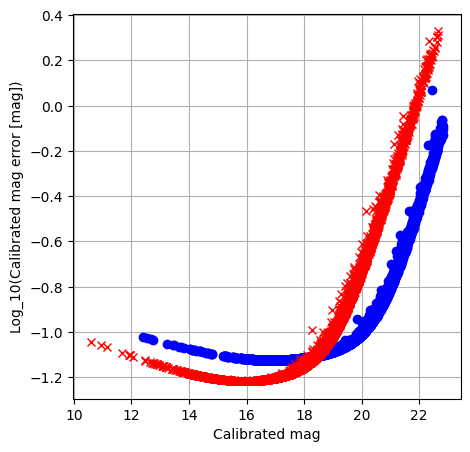

In [72]:
fig, ax = plt.subplots(1,1, figsize=(5,5))

ax.plot(cal_mag_gp, np.log10(err_cal_mag_gp), 'bo')
ax.plot(cal_mag_ip, np.log10(err_cal_mag_ip), 'rx')

ax.set_xlabel('Calibrated mag')
ax.set_ylabel('Log_10(Calibrated mag error [mag])')

plt.grid()
plt.show()

### Calibrate the timeseries photometry 

The microlensing pipeline calculates a photometric scale factor for each image to account for variations due to transparency, seeing, airmass etc.  The timeseries fluxes produced are already normalized relative to the scale factors.  

So having calculated the photometric calibration for a good-quality reference image, we can apply the same calibration to all images in 
the dataset.  

In [73]:
print('Calibrating timeseries data for gp...')
cal_mag_gp = np.zeros(dataset_gp.flux.shape)
err_cal_mag_gp = np.zeros(dataset_gp.err_flux.shape)
for i in range(0, dataset_gp.flux.shape[1], 1):
    if i%25 == 0: print('Working on image ' + str(i) + ' of ' + str(dataset_gp.flux.shape[1]))
    g_inst_mag, g_inst_err_mag, _, _ = conversions.flux_to_mag(dataset_gp.flux[:, i], dataset_gp.err_flux[:, i])
    cal_mag_gp[:,i], err_cal_mag_gp[:,i] = calc_calibrated_mags(pfit_gp, covar_fit_gp, g_inst_mag, g_inst_err_mag)

Calibrating timeseries data for gp...
Working on image 0 of 464
Working on image 25 of 464
Working on image 50 of 464
Working on image 75 of 464
Working on image 100 of 464
Working on image 125 of 464
Working on image 150 of 464
Working on image 175 of 464
Working on image 200 of 464
Working on image 225 of 464
Working on image 250 of 464
Working on image 275 of 464
Working on image 300 of 464
Working on image 325 of 464
Working on image 350 of 464
Working on image 375 of 464
Working on image 400 of 464
Working on image 425 of 464
Working on image 450 of 464


In [74]:
print('Calibrating timeseries data for ip...')
cal_mag_ip = np.zeros(dataset_ip.flux.shape)
err_cal_mag_ip = np.zeros(dataset_ip.err_flux.shape)
for i in range(0, dataset_ip.flux.shape[1], 1):
    if i%25 == 0: print('Working on image ' + str(i) + ' of ' + str(dataset_ip.flux.shape[1]))
    i_inst_mag, i_inst_err_mag, _, _ = conversions.flux_to_mag(dataset_ip.flux[:, i], dataset_ip.err_flux[:, i])
    cal_mag_ip[:,i], err_cal_mag_ip[:,i] = calc_calibrated_mags(pfit_ip, covar_fit_ip, i_inst_mag, i_inst_err_mag)
print(cal_mag_ip)

Calibrating timeseries data for ip...
Working on image 0 of 1073
Working on image 25 of 1073
Working on image 50 of 1073
Working on image 75 of 1073
Working on image 100 of 1073
Working on image 125 of 1073
Working on image 150 of 1073
Working on image 175 of 1073
Working on image 200 of 1073
Working on image 225 of 1073
Working on image 250 of 1073
Working on image 275 of 1073
Working on image 300 of 1073
Working on image 325 of 1073
Working on image 350 of 1073
Working on image 375 of 1073
Working on image 400 of 1073
Working on image 425 of 1073
Working on image 450 of 1073
Working on image 475 of 1073
Working on image 500 of 1073
Working on image 525 of 1073
Working on image 550 of 1073
Working on image 575 of 1073
Working on image 600 of 1073
Working on image 625 of 1073
Working on image 650 of 1073
Working on image 675 of 1073
Working on image 700 of 1073
Working on image 725 of 1073
Working on image 750 of 1073
Working on image 775 of 1073
Working on image 800 of 1073
Working on

Let's extract the calibrated lightcurve for the known microlensing event, convert to magnitudes and plot the lightcurve...

In [75]:
star_idx_ip, entry_ip = GC.find_nearest(dataset_ip.source_wcs, target.ra.deg, target.dec.deg, log=log)
star_idx_gp, entry_gp = GC.find_nearest(dataset_gp.source_wcs, target.ra.deg, target.dec.deg, log=log)

In [76]:
# Select the valid measurements
v1 = ~np.isnan(cal_mag_ip[star_idx_ip, :])
v2 = ~np.isnan(err_cal_mag_ip[star_idx_ip, :])
valid_ip = np.logical_and(v1, v2)

v1 = ~np.isnan(cal_mag_gp[star_idx_gp, :])
v2 = ~np.isnan(err_cal_mag_gp[star_idx_gp, :])
valid_gp = np.logical_and(v1, v2)

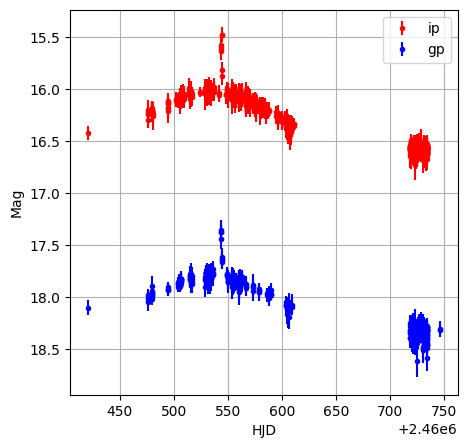

In [77]:
fig, ax = plt.subplots(1,1, figsize=(5,5))

ax.errorbar(
    dataset_ip.timestamps[valid_ip]['HJD'].data, 
    cal_mag_ip[star_idx_ip, valid_ip], 
    yerr=err_cal_mag_ip[star_idx_ip, valid_ip], 
    marker='.', 
    c='r', 
    ls='none',
    label='ip'
)
ax.errorbar(
    dataset_gp.timestamps[valid_gp]['HJD'].data, 
    cal_mag_gp[star_idx_gp, valid_gp], 
    yerr=err_cal_mag_gp[star_idx_gp, valid_gp], 
    marker='.', 
    c='b', 
    ls='none',
    label='gp'
)

ax.set_xlabel('HJD')
ax.set_ylabel('Mag')
ymin, ymax = ax.get_ylim() 
ax.set_ylim([ymax, ymin])

plt.grid()
plt.legend()
plt.show()

### Output 

We now store the calibrated photometry in an augmented version of the standard HDF5 file for timeseries photometry. 

First let's store the calibrated lightcurves we just extracted for ease of modeling.

In [78]:
file_path = path.join(args_ip.directory, 'cal_ob240034_ip.dat')
images = np.where(valid_ip)[0]
with open(file_path, 'w') as f:
    f.write('# HJD   cal_mag   err_cal_mag\n') 
    for i in images:
        f.write(
                str(dataset_ip.timestamps[i]['HJD']) + ' ' 
                + str(cal_mag_ip[star_idx_ip, i]) + ' ' 
                + str(err_cal_mag_ip[star_idx_ip, i]) + '\n'
        )

file_path = path.join(args_gp.directory, 'cal_ob240034_gp.dat')
images = np.where(valid_gp)[0]
with open(file_path, 'w') as f:
    f.write('# HJD   cal_mag   err_cal_mag\n') 
    for i in images:
        f.write(
                str(dataset_gp.timestamps[i]['HJD']) + ' ' 
                + str(cal_mag_gp[star_idx_gp, i]) + ' ' 
                + str(err_cal_mag_gp[star_idx_gp, i]) + '\n'
        )

In [79]:
def output_photometry(catalog, obs_set, flux, err_flux, cal_mag, err_cal_mag, pscales, epscales, ref_image_index, file_path, log=None):
    """
    Function to output a dataset photometry table to an HD5 file

    Parameters:
        catalog  Gaia catalog object containing all known objects in the field of view
        obs_set ObservationSet object for the current dataset
        flux    array  Normalized fluxes
        err_flux array Normalized flux uncertainties
        pscales array Photometric scale factor for each image and star
        epscales array Uncertainty on the scale factor per image and star
        ref_image_index  integer Index of reference image used for photometric calibration in data arrays
        file_path str Path to output file

    Returns:
        Output HDF5 file
    """

    # Build the source catalog
    source_id = catalog['source_id'].data
    source_radec = SkyCoord(ra=catalog['ra'], dec=catalog['dec'], unit=(u.degree, u.degree))
    wcs_positions = np.c_[catalog['ra'], catalog['dec']]
    im_wcs = lcowcs.build_wcs_from_obs_set(obs_set)
    positions = np.zeros((len(catalog), len(obs_set.table), 2))
    for i in range(1,len(obs_set.table),1):
        xx, yy = im_wcs[i].world_to_pixel(source_radec)
        positions[:,i,0] = xx
        positions[:,i,1] = yy
    positions = np.array(positions)

    with h5py.File(file_path, "w") as f:
        d1 = f.create_dataset(
            'source_id',
            source_id.shape,
            dtype='int64',
            data=source_id
        )

        d2 = f.create_dataset(
            'source_wcs',
            wcs_positions.shape,
            dtype='float64',
            data=wcs_positions
        )

        d3 = f.create_dataset(
            'positions',
            positions.shape,
            dtype='float64',
            data=positions
        )

        d4 = f.create_dataset(
            'HJD',
            len(obs_set.table['HJD']),
            dtype='float64',
            data=obs_set.table['HJD'].data
        )

        d5 = f.create_dataset(
            'flux',
            flux.shape,
            dtype='float64',
            data=flux
        )

        d6 = f.create_dataset(
            'err_flux',
            err_flux.shape,
            dtype='float64',
            data=err_flux
        )

        d7 = f.create_dataset(
            'cal_mag',
            cal_mag.shape,
            dtype='float64',
            data=cal_mag
        )

        d8 = f.create_dataset(
            'err_cal_mag',
            err_cal_mag.shape,
            dtype='float64',
            data=err_cal_mag
        )
        
        d9 = f.create_dataset(
            'pscale',
            pscales.shape,
            dtype='float64',
            data=pscales
        )

        d10 = f.create_dataset(
            'epscale',
            epscales.shape,
            dtype='float64',
            data=epscales
        )

        d11 = f.create_dataset(
            'ref_image_index',
            1,
            dtype='float64',
            data=ref_image_index
        )
        
    f.close()

In [80]:
file_path = path.join(args_gp.directory, 'cal_aperture_photometry.hdf5')
output_photometry(
    gaia_catalog_gp, 
    obs_set_gp, 
    dataset_gp.flux, 
    dataset_gp.err_flux, 
    cal_mag_gp, 
    err_cal_mag_gp, 
    dataset_gp.pscale, 
    dataset_gp.epscale, 
    ref_index_gp,
    file_path
)

In [81]:
file_path = path.join(args_ip.directory, 'cal_aperture_photometry.hdf5')
output_photometry(
    gaia_catalog_ip, 
    obs_set_ip, 
    dataset_ip.flux, 
    dataset_ip.err_flux, 
    cal_mag_ip, 
    err_cal_mag_ip, 
    dataset_ip.pscale, 
    dataset_ip.epscale, 
    ref_index_ip,
    file_path
)

### Color Magnitude Diagram 

We can now use the calibrated photometry from the two reference images (selected from observations from the same day, telescope and instrument) to make a color-magnitude diagram. 

If the pipeline used a single Gaia catalog for both datasets, this would be straightforward since the arrays would have the same stellar index.  Currently however, gp and ip data have very similar but different catalogs.  So our first step here will have to be to identify stars that are present in both catalogs.  

This can be done by comparing the gaia_catalog source_id columns. 

In [82]:
gindex = [] 
iindex = []
for jg,gid in enumerate(gaia_catalog_gp['source_id']):
    if gid in gaia_catalog_ip['source_id']: 
        ji = np.where(gaia_catalog_ip['source_id'] == gid)[0][0]
        gindex.append(jg)
        iindex.append(int(ji))

In [83]:
# Calculate the SDSS-(g-i) colors for all stars in the reference images
gpip = cal_mag_gp[gindex,ref_index_gp] - cal_mag_ip[iindex, ref_index_ip]

err_gpip = np.sqrt(
    err_cal_mag_gp[gindex,ref_index_gp]*err_cal_mag_gp[gindex,ref_index_gp] 
    + err_cal_mag_ip[iindex, ref_index_ip]*err_cal_mag_ip[iindex, ref_index_ip]
)

In [84]:
# We haven't yet filtered out invalid entries, so let's do that now
idx1 = cal_mag_gp[gindex,ref_index_gp] > 0.0
idx2 = cal_mag_ip[iindex, ref_index_ip] > 0.0
idx = idx1 & idx2

In [85]:
# Find our target star in both indices and calculate its colors
star_idx_gp, entry = GC.find_nearest(dataset_gp.source_wcs, target.ra.deg, target.dec.deg, log=log)
star_idx_ip, entry = GC.find_nearest(dataset_ip.source_wcs, target.ra.deg, target.dec.deg, log=log)

star_gpip = cal_mag_gp[star_idx_gp,ref_index_gp] - cal_mag_ip[star_idx_ip, ref_index_ip]
star_err_gpip = np.sqrt(
    err_cal_mag_gp[star_idx_gp,ref_index_gp]*err_cal_mag_gp[star_idx_gp,ref_index_gp] 
    + err_cal_mag_ip[star_idx_ip, ref_index_ip]*err_cal_mag_ip[star_idx_ip, ref_index_ip]
)

print('Target calibrated photometry:')
print(
    'g = ' + str(round(cal_mag_gp[star_idx_gp,ref_index_gp],3)) 
    + 'mag, i = ' + str(round(cal_mag_ip[star_idx_ip, ref_index_ip], 3)) 
    + 'mag, g-i = ' + str(round(star_gpip,3)) + ' +/- ' + str(round(star_err_gpip,3)) + 'mag')

Target calibrated photometry:
g = 17.784mag, i = 16.009mag, g-i = 1.774 +/- 0.097mag


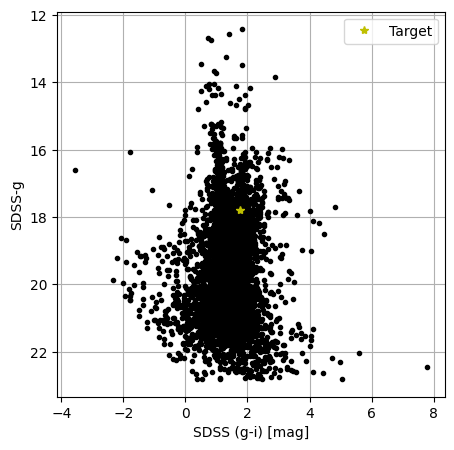

In [86]:
fig, ax = plt.subplots(1,1, figsize=(5,5))

ax.plot(gpip[idx], cal_mag_gp[gindex,ref_index_gp][idx], 'k.')
ax.plot(star_gpip, cal_mag_gp[star_idx_gp,ref_index_gp], 'y*', label='Target')

ax.set_xlabel('SDSS (g-i) [mag]')
ax.set_ylabel('SDSS-g')
ymin, ymax = ax.get_ylim() 
ax.set_ylim([ymax, ymin])

plt.grid()
plt.legend()
plt.show()

Lastly, we can output this photometry to a text file for future use.

In [87]:
file_path = '/Users/rstreet/OMEGAII/data_reduction/OGLE-2024-BLG-0034/OB240034_color_phot.dat'

phot_table = Table([
    Column(name='star_index_gp', data=np.array(gindex)[idx]), 
    Column(name='star_index_ip', data=np.array(iindex)[idx]),
    Column(name='cal_mag_g', data=cal_mag_gp[gindex,ref_index_gp][idx]),
    Column(name='err_cal_mag_g', data=err_cal_mag_gp[gindex,ref_index_gp][idx]),
    Column(name='cal_mag_i', data=cal_mag_ip[iindex, ref_index_ip][idx]),
    Column(name='err_cal_mag_i', data=err_cal_mag_ip[iindex,ref_index_ip][idx]),
    Column(name='gp_ip', data=gpip[idx]),
    Column(name='err_gp_ip', data=err_gpip[idx])
])

ascii.write(phot_table, file_path, overwrite=True)